In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from global_land_mask import globe

from shapely.geometry import LineString
from shapely.ops import split, transform
from cartopy.mpl.patch import geos_to_path
from matplotlib.patches import PathPatch
from matplotlib.colors import ListedColormap

from functions.latex import set_size
from skimage import measure
from cartopy.util import add_cyclic_point

datadir = "../data/"
figdir = "../figures/"

In [2]:
def get_region_coords(region_name="arctic_ocean", xy=False):
    region_dict = {
        "arctic_ocean": {False: [-180, 180, 60, 90], True: [65, 185, 0, 215]},
        "canada_basin": {False: [-180, -95, 70, 85], True: [70, 130, 135, 205]},
        "amerasian_basin": {False: [], True: [70, 160, 120, 205]},
        "eurasian_basin": {False: [-180, 180, 78, 90], True: [110, 180, 80, 170]},
        "makarov_basin": {False: [-180, 180, 78, 90], True: [110, 155, 120, 190]},
        "greenland_basin": {False: [-15, 15, 72, 80], True: [110, 145, 50, 85]},
        "lofoten_basin": {False: [-5, 13.5, 68, 73], True: [125, 145, 30, 55]},
        "norwegian_basin": {False: [-8, 3, 63, 71], True: [115, 135, 15, 45]},
        "norwegian_seas": {False: [-15, 15, 62, 73], True: [115, 155, 10, 55]},
        "nordic_seas": {False: [-15, 15, 62, 73], True: [75, 175, 0, 90]},
    }
    
    if region_name not in region_dict:
        raise ValueError("Undefined region, please check spelling.")
    
    return region_dict[region_name][xy]

def create_map(region, subplots=(1, 1), **kwargs):
    #if region_name == "arctic_mediterranean":
    if (region[0] + region[1] == 0) and region[-1] == 90:
        proj = ccrs.NorthPolarStereo()
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        shape = mpath.Path(verts * radius + center)
    else:
        proj = ccrs.LambertConformal(central_longitude=(region[0] + region[1])/2,
                                     central_latitude=(region[2] + region[3])/2
                                    )
        n = 20
        shape = mpath.Path(
            list(zip(np.linspace(region[0], region[1], n), np.full(n, region[3]))) + \
            list(zip(np.full(n, region[1]), np.linspace(region[3], region[2], n))) + \
            list(zip(np.linspace(region[1], region[0], n), np.full(n, region[2]))) + \
            list(zip(np.full(n, region[0]), np.linspace(region[2], region[3], n)))
        )
    fig, axes = plt.subplots(subplots[0], subplots[1],
                             subplot_kw={"projection" : proj},
                             **kwargs
                            )
    if np.sum(subplots) == 2:
        #if region_name == "arctic_mediterranean":
        if (region[0] + region[1] == 0) and region[-1] == 90:
            transform = axes.transAxes
            crs = ccrs.PlateCarree()
        else:
            transform = ccrs.PlateCarree()
            crs = None
        axes.set_extent(region, crs=ccrs.PlateCarree())
        axes.set_boundary(shape, transform=transform)
        axes.coastlines()
        """
        axes.gridlines(draw_labels=draw_gridlabels,
                       rotate_labels=False,
                       x_inline=False,
                       y_inline=False
                      )
        """
        axes.add_feature(cfeature.LAND, color="grey", zorder=100)
    else:
        for ax in axes.flatten():
            #if region_name == "arctic_mediterranean":
            if (region[0] + region[1] == 0) and region[-1] == 90:
                transform = ax.transAxes
                crs = ccrs.PlateCarree()
            else:
                transform = ccrs.PlateCarree()
                crs = None
            ax.set_extent(region, crs=crs)
            ax.set_boundary(shape, transform=transform)
            ax.coastlines()
            """
            ax.gridlines(draw_labels=draw_gridlabels,
                         rotate_labels=False,
                         x_inline=False,
                         y_inline=False
                        )
            """
            ax.add_feature(cfeature.LAND, color="grey", zorder=100)
    return fig, axes

def split_antimeridian(lons, lats):
    """Split lines that cross the dateline into segments."""
    coords = np.column_stack((lons, lats))
    segments = []
    current = [coords[0]]

    for i in range(1, len(coords)):
        lon1, lat1 = coords[i-1]
        lon2, lat2 = coords[i]
        if abs(lon2 - lon1) > 180:
            # crossing detected
            if lon1 > 0:
                lon2 += 360
            else:
                lon1 += 360
            mid_lon = (lon1 + lon2) / 2
            #mid_lon = (mid_lon + 180) % 360 - 180  # wrap back to [-180, 180]
            mid_lat = (lat1 + lat2) / 2
            current.append([mid_lon, mid_lat])
            segments.append(np.array(current))
            current = [[(lon2 + 180) % 360 - 180, lat2]]
            #current = [[lon2, lat2]]
        else:
            current.append([lon2, lat2])
    segments.append(np.array(current))
    return segments

def normalize_longitudes(lons):
    """Wrap longitudes into [-180, 180]"""
    return (np.array(lons) + 180) % 360 - 180

def make_linestring(lons, lats):
    lons = normalize_longitudes(lons)
    return LineString(zip(lons, lats))

region_contours = {
    #"arctic_ocean" : [800, 1000, 1250, 1500, 1800, 2000, 2300],
    "arctic_ocean" : [1000, 1200, 1400, 1600, 1800, 2000, 2200],
    #"canada_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3750],
    "canada_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800],
    #"makarov_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800],
    "makarov_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800],
    #"eurasian_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200],
    "eurasian_basin" : [2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200],
    #"greenland_basin" : [2550, 2625, 2800, 3000, 3200, 3400, 3600],
    #"greenland_basin" : [2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700],
    "greenland_basin" : [2600, 2800, 3000, 3200, 3400, 3600],
    #"norwegian_seas" : [2500, 2700, 2900, 3050],
    "norwegian_seas" : [2700, 2800, 2900, 3000, 3100, 3200],
    #"lofoten_basin" : [3150, 3200],
    "lofoten_basin" : [3350, 3400, 3450],
    #"norwegian_basin" : [3150, 3275, 3450, 3600]
    #"norwegian_basin" : [3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850, 3900]
    "norwegian_basin" : [3400, 3500, 3600, 3700, 3800, 3900]
}

In [3]:
ds = xr.open_dataset(datadir + "bathymetry_with_gradients_filter50_ease.nc")
ds

<xarray.Dataset> Size: 3MB
Dimensions:  (y: 264, x: 264)
Coordinates:
    lat      (y, x) float32 279kB ...
    lon      (y, x) float32 279kB ...
  * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
Data variables:
    depth    (y, x) float64 558kB ...
    dhdx     (y, x) float64 558kB ...
    dhdy     (y, x) float64 558kB ...
    slope    (y, x) float64 558kB ...

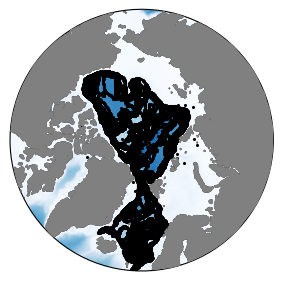

In [6]:
fig, ax = create_map(get_region_coords("arctic_ocean"),
                     figsize=set_size(width="AGU")
                    )
levels = np.arange(0, 5850, 250)
cmap = plt.get_cmap("Blues")
"""
c = ax.contourf(ds.lon, ds.lat, ds.depth,
                transform=ccrs.PlateCarree(),
                levels=levels,
                #levels=np.linspace(10, 600, 15),
                cmap=cmap
               )
"""

c = ax.pcolormesh(ds.lon, ds.lat, ds.depth,
                  transform=ccrs.PlateCarree(),
                  vmin=0,
                  vmax=5600,
                  cmap=cmap
                 )

for region_name in region_contours:
    contour_depths = region_contours[region_name]
    for contour_depth in contour_depths:
        contour = xr.open_dataset(datadir + region_name + "/contour_eff_" + str(contour_depth) + ".nc")
        ds_interp = ds.interp(x=contour.x, y=contour.y)
        ax.scatter(x=ds_interp.lon, y=ds_interp.lat,
                   c="black",
                   #alpha=1,
                   s=5,
                   linewidth=0,
                   transform=ccrs.PlateCarree()
                  )

                   
fig.savefig(figdir + f"geographical_context.png", dpi=300, bbox_inches="tight")

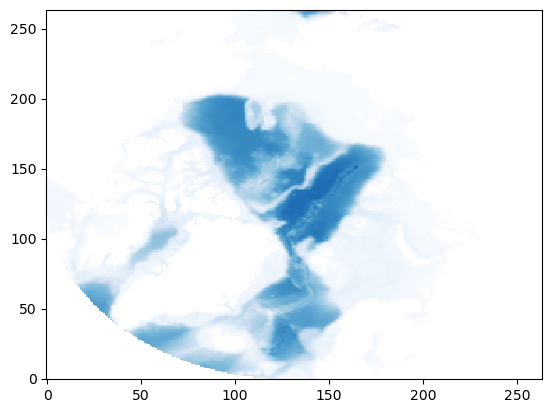

In [25]:
fig, ax = plt.subplots()

c = ax.pcolormesh(ds.x, ds.y, ds.depth,
                  vmin=0,
                  vmax=5600,
                  cmap=cmap
                 )

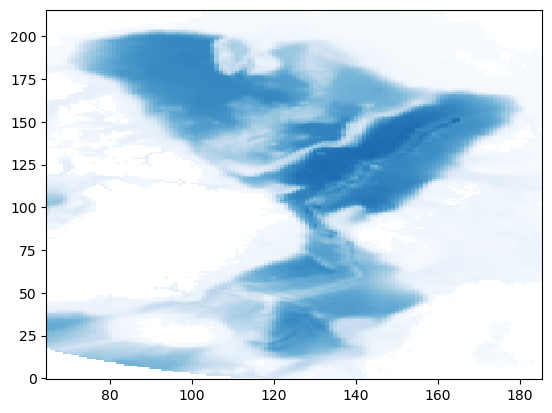

In [27]:
ds_sel = ds.sel(x=slice(65, 185), y=slice(0, 215))

fig, ax = plt.subplots()

c = ax.pcolormesh(ds_sel.x, ds_sel.y, ds_sel.depth,
                  vmin=0,
                  vmax=5600,
                  cmap=cmap
                 )

In [28]:
ds_sel = ds_sel.drop_sel(x=slice(0, 85), y=slice(0, 125))

fig, ax = plt.subplots()

c = ax.pcolormesh(ds_sel.x, ds_sel.y, ds_sel.depth,
                  vmin=0,
                  vmax=5600,
                  cmap=cmap
                 )

TypeError: unhashable type: 'slice'

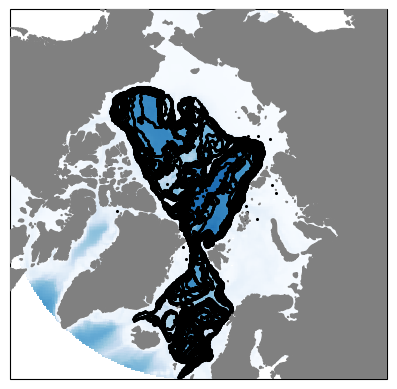

In [11]:
"""
fig, ax = create_map(get_region_coords("arctic_ocean"),
                     figsize=set_size(width="AGU")
                    )
"""
fig, ax = plt.subplots(1, 1,
                           #figsize=set_size(width="AGU"),
                           subplot_kw={"projection" : ccrs.Stereographic(central_latitude=90)}
                          )
levels = np.arange(0, 5850, 250)
cmap = plt.get_cmap("Blues")
"""
c = ax.contourf(ds.lon, ds.lat, ds.depth,
                transform=ccrs.PlateCarree(),
                levels=levels,
                #levels=np.linspace(10, 600, 15),
                cmap=cmap
               )
"""

c = ax.pcolormesh(ds.lon, ds.lat, ds.depth,
                  transform=ccrs.PlateCarree(),
                  vmin=0,
                  vmax=5600,
                  cmap=cmap
                 )
ax.add_feature(cfeature.LAND, color="grey", zorder=100)
ax.set_extent([-160, 160, 60, 90], crs=ccrs.PlateCarree())
for region_name in region_contours:
    contour_depths = region_contours[region_name]
    for contour_depth in contour_depths:
        contour = xr.open_dataset(datadir + region_name + "/contour_eff_" + str(contour_depth) + ".nc")
        ds_interp = ds.interp(x=contour.x, y=contour.y)
        ax.scatter(x=ds_interp.lon, y=ds_interp.lat,
                   c="black",
                   #alpha=1,
                   s=5,
                   linewidth=0,
                   transform=ccrs.PlateCarree()
                  )

                   
fig.savefig(figdir + f"geographical_context.png", dpi=300, bbox_inches="tight")

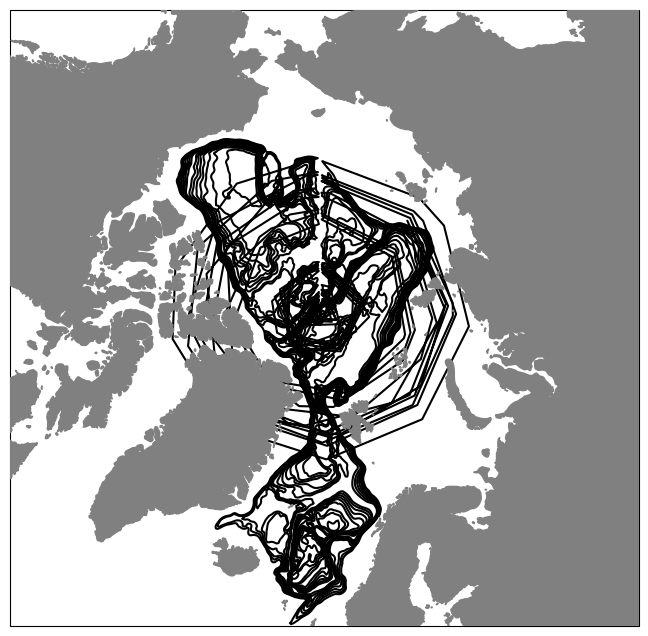

In [32]:
"""
fig, ax = create_map(get_region_coords("arctic_ocean"),
                     figsize=set_size(width="AGU")
                    )
"""
fig, ax = plt.subplots(1, 1,
                           #figsize=set_size(width="AGU"),
                           figsize=(10, 8),
                           subplot_kw={"projection" : ccrs.Stereographic(central_latitude=90)}
                          )
levels = np.arange(0, 5850, 250)
cmap = plt.get_cmap("Blues")
"""
c = ax.contourf(ds.lon, ds.lat, ds.depth,
                transform=ccrs.PlateCarree(),
                levels=levels,
                #levels=np.linspace(10, 600, 15),
                cmap=cmap
               )
"""
ax.add_feature(cfeature.LAND, color="grey", zorder=100)
ax.set_extent([-160, 160, 60, 90], crs=ccrs.PlateCarree())
for region_name in region_contours:
    contour_depths = region_contours[region_name]
    for contour_depth in contour_depths:
        contour = xr.open_dataset(datadir + region_name + "/contour_eff_" + str(contour_depth) + ".nc")
        ds_interp = ds.interp(x=contour.x, y=contour.y)
        ax.plot(ds_interp.lon, ds_interp.lat,
                   c="black",
                   transform=ccrs.PlateCarree()
                  )

'\nax.pcolormesh(land_mask.x, land_mask.y, land_mask,\n            cmap="Greys",\n            vmax=1\n            )\n'

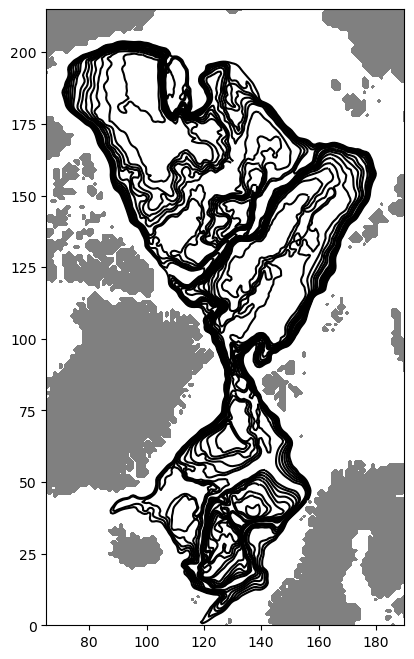

In [86]:
"""
fig, ax = create_map(get_region_coords("arctic_ocean"),
                     figsize=set_size(width="AGU")
                    )
"""

#nan_mask = np.isnan(ds.depth).astype(int)
nan_mask = (ds.depth == 0).astype(int)
is_on_land = globe.is_land(ds.lat, ds.lon)
land_mask = xr.DataArray(is_on_land, coords=[ds.y, ds.x], dims=["y", "x"])

# Coordinates
x = np.arange(land_mask.shape[1])
y = np.arange(land_mask.shape[0])
X, Y = np.meshgrid(land_mask.x, land_mask.y)

fig, ax = plt.subplots(1, 1,
                           #figsize=set_size(width="AGU"),
                           figsize=(10, 8)
                          )
for region_name in region_contours:
    contour_depths = region_contours[region_name]
    for contour_depth in contour_depths:
        contour = xr.open_dataset(datadir + region_name + "/contour_eff_" + str(contour_depth) + ".nc")
        ds_interp = ds.interp(x=contour.x, y=contour.y)
        ax.plot(ds_interp.x, ds_interp.y,
                   c="black"
                  )

ax.set_xlim(65, 190)
ax.set_ylim(0, 215)
ax.set_aspect(1)


ax.contourf(X, Y, land_mask, levels=[0.5, 1.5], colors=['grey'])  # Only fill where value is 1 (NaN)
"""
ax.pcolormesh(land_mask.x, land_mask.y, land_mask,
            cmap="Greys",
            vmax=1
            )
"""
        

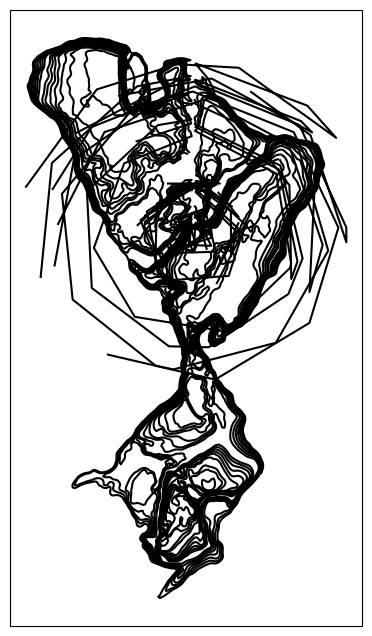

In [20]:
fig, ax = plt.subplots(1, 1,
                           #figsize=set_size(width="AGU"),
                           figsize=(10, 8),
                           subplot_kw={"projection" : ccrs.Stereographic(central_latitude=90)}
                          )
levels = np.arange(0, 5850, 250)
cmap = plt.get_cmap("Blues")

for region_name in region_contours:
    contour_depths = region_contours[region_name]
    for contour_depth in contour_depths:
        contour = xr.open_dataset(datadir + region_name + "/contour_eff_" + str(contour_depth) + ".nc")
        ds_interp = ds.interp(x=contour.x, y=contour.y)
        lons = ds_interp.lon.values
        lats = ds_interp.lat.values

        segments = split_antimeridian(lons, lats)
        for seg in segments:
            ax.plot(seg[:, 0], seg[:, 1],
                    c="black",
                    transform=ccrs.PlateCarree()
                   )

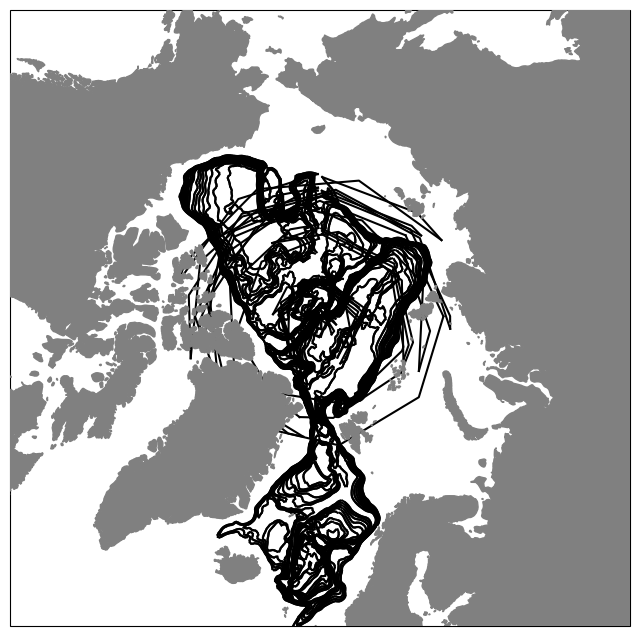

In [ ]:
"""
fig, ax = create_map(get_region_coords("arctic_ocean"),
                     figsize=set_size(width="AGU")
                    )
"""
fig, ax = plt.subplots(1, 1,
                           #figsize=set_size(width="AGU"),
                           figsize=(10, 8),
                           subplot_kw={"projection" : ccrs.Stereographic(central_latitude=90)}
                          )
levels = np.arange(0, 5850, 250)
cmap = plt.get_cmap("Blues")
"""
c = ax.contourf(ds.lon, ds.lat, ds.depth,
                transform=ccrs.PlateCarree(),
                levels=levels,
                #levels=np.linspace(10, 600, 15),
                cmap=cmap
               )
"""
ax.add_feature(cfeature.LAND, color="grey", zorder=100)
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
for region_name in region_contours:
    contour_depths = region_contours[region_name]
    for contour_depth in contour_depths:
        contour = xr.open_dataset(datadir + region_name + "/contour_eff_" + str(contour_depth) + ".nc")
        ds_interp = ds.interp(x=contour.x, y=contour.y)
        
        lat = ds_interp.lat.values
        lon = ds_interp.lon.values
        ax.plot(ds_interp.x, ds_interp.y,
                   c="black"
                  )
        """
        for i in range(len(lon)-1):
            loni = lon[i]
            if np.abs(lon[i+1] - loni) > 180:
                if loni < 0:
                    loni += 360
                else:
                    loni -= 360 
            
            ax.plot([loni, lon[i+1]], [lat[i], lat[i+1]],
                    c="black",
                    transform=ccrs.PlateCarree()
                    )
        """

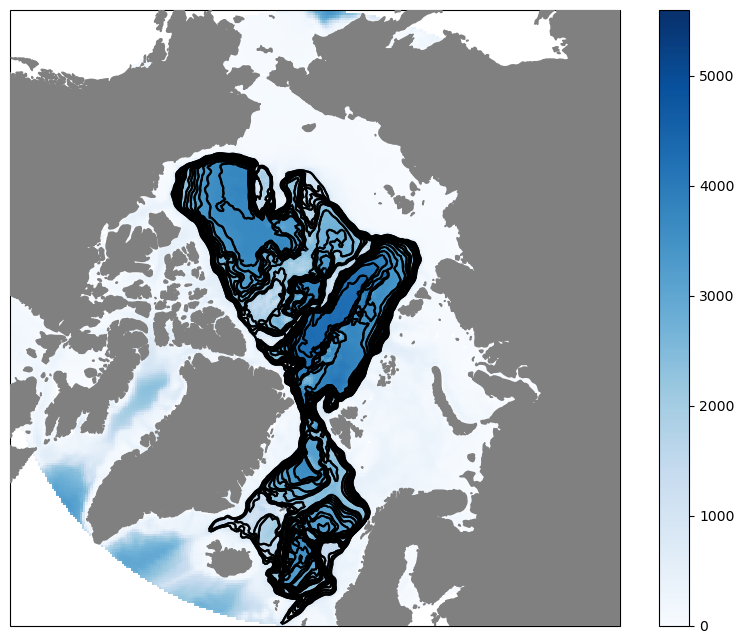

In [ ]:
fig, ax = plt.subplots(1, 1,
                           #figsize=set_size(width="AGU"),
                           figsize=(10, 8),
                           subplot_kw={"projection" : ccrs.Stereographic(central_latitude=90)}
                          )
levels = np.linspace(0, 5600, 22)
cmap = plt.get_cmap("Blues")
"""
c = ax.contourf(ds.lon, ds.lat, ds.depth,
                transform=ccrs.PlateCarree(),
                levels=levels,
                #levels=np.linspace(10, 600, 15),
                cmap=cmap
               )
"""
ax.add_feature(cfeature.LAND, color="grey", zorder=100)
#ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())

# this is for the region close to the dateline 
ds_copy = ds.copy(deep=True)
# Create a condition mask
mask_copy = ds_copy.lon < 0
ds_copy = ds.assign_coords(
            lon=xr.where(mask_copy, ds.lon+360, ds.lon)
        )

for region_name in region_contours:
    contour_depths = region_contours[region_name]
    for contour_depth in contour_depths:
        contour = xr.open_dataset(datadir + region_name + "/contour_eff_" + str(contour_depth) + ".nc")
        
        ds_interp = ds.interp(x=contour.x, y=contour.y, method="linear")
        ds_copy_interp = ds_copy.interp(x=contour.x, y=contour.y, method="linear")
        

        #ds_interp = ds_interp.assign_coords(
        #    lon=xr.where(np.abs(ds_copy_interp.lon - 180) < 1, ds_copy_interp.lon, ds_interp.lon)
        #)

        ds_interp = ds_interp.assign_coords(
            lon=xr.where(np.abs(ds_interp.lon) < 1, ds_interp.lon, ds_copy_interp.lon)
        )


        lat = ds_interp.lat.values
        lon = ds_interp.lon.values
        for i in range(len(lon)-1):
        #for i in range(291):
            loni = lon[i]
            if np.abs(lon[i+1] - loni) > 180:
                #print(i)
                if loni < 0:
                    loni += 360
                else:
                    loni -= 360
            
            ax.plot([loni, lon[i+1]], [lat[i], lat[i+1]],
                    c="black",
                    transform=ccrs.PlateCarree()
                    )
c = ax.pcolormesh(ds.lon, ds.lat, ds.depth,
                  transform=ccrs.PlateCarree(),
                  vmin=0,
                  vmax=5600,
                  cmap=cmap
                 )
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
fig.colorbar(c)